In [1]:
#part 1
import pandas as pd

df = pd.read_json("logins.json")
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [2]:
df.info()
df.count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


login_time    93142
dtype: int64

In [3]:
df_15mins = (
    df
    .set_index("login_time")
    .resample("15min")          # 15-minute intervals
    .size()                   # count logins
    .rename("login_count")
    .reset_index()
)

df_15mins.head()

,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


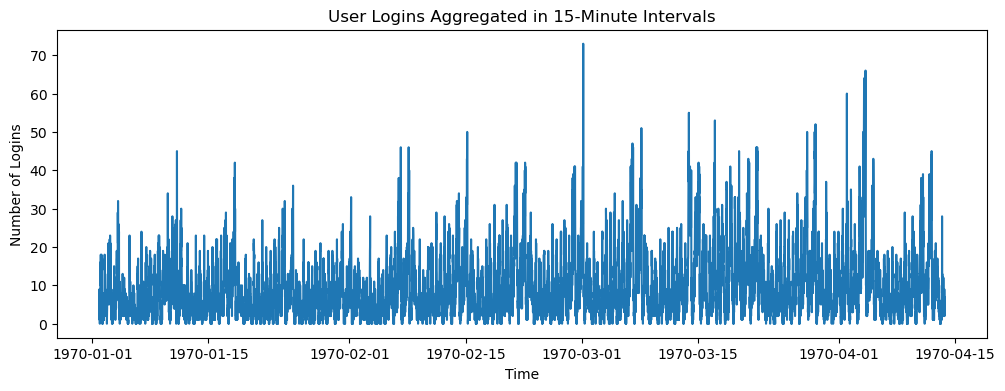

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df_15mins["login_time"], df_15mins["login_count"])
plt.title("User Logins Aggregated in 15-Minute Intervals")
plt.xlabel("Time")
plt.ylabel("Number of Logins")
plt.show()

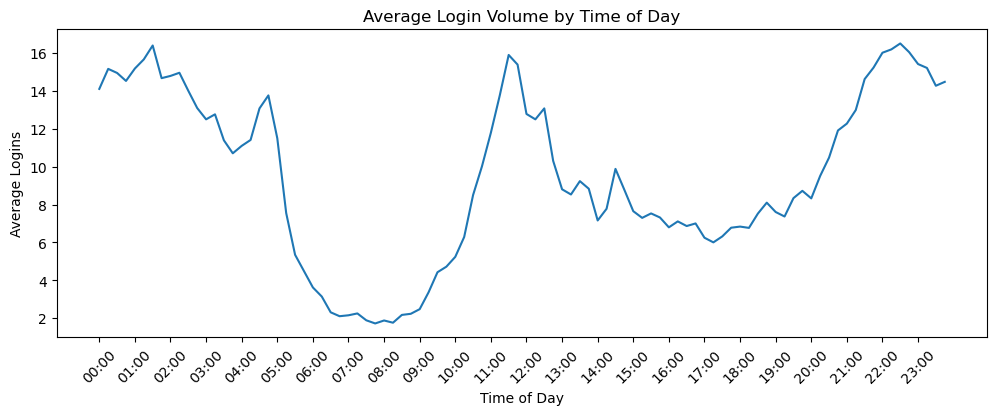

In [5]:
df_15mins["hour"] = df_15mins["login_time"].dt.hour
df_15mins["minute"] = df_15mins["login_time"].dt.minute

daily_pattern = (
    df_15mins
    .groupby(["hour", "minute"])["login_count"]
    .mean()
    .reset_index()
)

daily_pattern["time_of_day"] = (
    daily_pattern["hour"].astype(str).str.zfill(2) + ":" +
    daily_pattern["minute"].astype(str).str.zfill(2)
)

plt.figure(figsize=(12,4))
plt.plot(daily_pattern["time_of_day"], daily_pattern["login_count"])

tick_idx = range(0, len(daily_pattern), 4)

plt.xticks(
    ticks=tick_idx,
    labels=daily_pattern.loc[tick_idx, "time_of_day"],
    rotation=45
)

plt.title("Average Login Volume by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Average Logins")
plt.show()

In [7]:

df = pd.read_json("ultimate_data_challenge.json")
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


#Part 2 ‐ Experiment and metrics design
To test whether reimbursing bridge tolls increases driver supply in both Gotham and Metropolis, I would run a randomized controlled experiment at the driver level. 
1)The primary success metric would be the share of drivers who are active in both cities during the experiment window (e.g., weekly): a driver is “multi-city active” if they complete at least one trip in Gotham and at least one trip in Metropolis within the same week. This directly measures the behavioral whether more drivers choose to serve across cities rather than relying only on total trip volume, which can be influenced by demand fluctuations. 
2)Key secondary metrics would include: number and share of cross-city trips (origin and destination in different cities),  online/available minutes by city and by day-part (weekday vs. weekend, and peak vs. off-peak), rider experience metrics such as ETA, match rate, cancellation rate, and driver outcomes and program economics such as net earnings per hour and toll reimbursement cost.

For the experiment, I would define an eligible driver population (e.g., drivers who have driven within either city in the last N weeks) and randomly assign drivers into Treatment and Control, using stratified randomization to balance important pre-experiment factors such as home city, historical activity level, and historical cross-city behavior. Treatment drivers would receive automatic 100% reimbursement of bridge tolls for verified toll-incurring trips; Control drivers would experience same as before. The experiment should run for at least 4–6 weeks to cover multiple full weekday/weekend cycles and reduce noise from short-term demand shocks. Reimbursement should be clearly communicated in-app and paid quickly (e.g., next day) to ensure drivers perceive the incentive and to reduce friction. Use geofences around each city and the bridge to confirm a trip truly crossed the bridge before reimbursing the toll.

For analysis, the primary metric is a proportion, so I would compare Treatment vs. Control using a two-proportion z-test / chi-square test, and also estimate a logistic regression with “multi-city active” as the dependent variable and a treatment indicator plus baseline covariates (pre-period trips, city, historical cross-city frequency) to improve precision and interpret the treatment uplift (odds ratio and confidence interval). For secondary continuous outcomes (e.g., ETA, online minutes), I would use difference-in-differences or regression with pre-period controls (and ideally CUPED) and compute cluster-robust standard errors at the driver level to account for repeated observations per driver. For count outcomes (e.g., cross-city trips), I would use Poisson/negative binomial regression as appropriate.

Interpreting results: if the Treatment group shows a statistically and practically significant increase in the share of multi-city active drivers, and this improvement aligns with better rider experience (lower ETA/higher match rate) without excessive cancellations, then toll reimbursement is likely effective. I would also quantify program efficiency as incremental cost per incremental multi-city active driver-week and evaluate ROI via changes in completed trips or reduced unfulfilled demand. If the effect is weak or not significant, potential explanations include insufficient incentive salience (drivers do not notice or trust reimbursement), non-monetary barriers (time cost, congestion, or return-trip uncertainty), or market spillovers. Key caveats include interference/spillover effects (treated drivers may affect market conditions for controls), demand seasonality, and measurement error in detecting toll crossings. Based on heterogeneous treatment effects, I would consider a targeted rollout (e.g., only certain day-parts or driver segments) to maximize impact per dollar spent.

In [12]:
#part3
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

# 1) Load data (改成你本地文件路径)
df = pd.read_json("ultimate_data_challenge.json")

# 2) Parse dates
df["signup_date"] = pd.to_datetime(df["signup_date"])
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])
df["account_age_days"] = (as_of_date - df["signup_date"]).dt.days

# 3) Create target: retained = active in the preceding 30 days (relative to as-of date)
as_of_date = df["last_trip_date"].max()
cutoff = as_of_date - pd.Timedelta(days=30)
df["retained"] = (df["last_trip_date"] >= cutoff).astype(int)

# Print as_of_date max and cutoff date and retained rate
print("as_of_date:", as_of_date.date(), "cutoff:", cutoff.date())
print("retained rate:", df["retained"].mean())

# 4) Features / target
y = df["retained"]
X = df.drop(columns=["retained", "last_trip_date", "signup_date"])

# 5) Preprocess
cat_cols = ["city", "phone"]
bool_cols = ["ultimate_black_user"]
num_cols = [
    "avg_dist", "avg_rating_by_driver", "avg_rating_of_driver",
    "surge_pct", "avg_surge", "trips_in_first_30_days", "weekday_pct","account_age_days"
]

# Some datasets store bool as True/False; keep it numeric 0/1
X[bool_cols] = X[bool_cols].astype(int)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols + bool_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

# 6) Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7) Train model  ✅ 这里会真正创建变量 model
model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000))
])

model.fit(X_train, y_train)

# 8) Evaluate (basic)
proba = model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)
print(proba)
print(pred)
print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred))


as_of_date: 2014-07-01 cutoff: 2014-06-01
retained rate: 0.37608
[0.42170082 0.51504433 0.48345171 ... 0.26595424 0.15413695 0.55525033]
[0 1 0 ... 0 0 1]
ROC-AUC: 0.7538003711845265
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      6239
           1       0.67      0.49      0.57      3761

    accuracy                           0.72     10000
   macro avg       0.70      0.67      0.68     10000
weighted avg       0.71      0.72      0.71     10000



1) Cleaning / EDA / Retention fraction

Data preparation. I loaded the JSON dataset into a pandas DataFrame and converted signup_date and last_trip_date into datetime fields. I checked for missing values and handled them using simple imputations: numeric features were imputed with the median and categorical features (city, phone) were imputed with the most frequent category. Boolean ultimate_black_user was cast to 0/1. I also verified category levels (e.g., device types) and examined basic distributions of key usage variables such as trips_in_first_30_days, avg_dist, surge_pct, and weekday_pct.

Target definition (retained). Following the problem definition, a user is considered retained if they completed at least one trip in the preceding 30 days relative to a snapshot date. Since an explicit snapshot date is not provided, I approximated it as the maximum observed last_trip_date in the dataset, and labeled users as retained if last_trip_date >= snapshot_date - 30 days. (This assumption is a minor limitation and could shift the exact retention rate slightly if the true snapshot date differs.)

Retention fraction. Using this definition, the fraction of observed users who were retained is 0.376 (≈ 37.6%).
I also perform normalization for 


2) Predictive model, rationale, validity, and performance

I built a baseline classification model using Logistic Regression with a preprocessing pipeline. Logistic Regression is a strong first-choice for this problem because it is fast and stable on tabular data.

Features and preprocessing. As mentioned above Numerical features (avg_dist, avg_rating_by_driver, avg_rating_of_driver, surge_pct, avg_surge, trips_in_first_30_days, weekday_pct) were median-imputed, and categorical features (city, phone) were most-frequent-imputed and one-hot encoded with handle_unknown="ignore". I used an 80/20 train–test split with stratify=y to preserve the class balance across splits.

The model is much stronger at identifying non-retained users (class 0 recall = 0.85) than retained users (class 1 recall = 0.49). This suggests a conservative decision boundary that predicts “not retained” frequently; tuning the probability threshold (or using class weighting) could increase recall for the retained class if desired.

3)
two practical ways:

Targeted retention interventions. Use predicted probabilities to segment users by churn risk (e.g., top risk decile). High-risk users can receive tailored offers or nudges—such as ride credits, reactivation campaigns, or reminders—while low-risk users receive minimal incentives, improving the efficiency/ROI of retention spend.

Product and operational insights. The most predictive features (often early engagement signals like trips_in_first_30_days, and contextual variables such as surge_pct, weekday_pct, city, and device type) can guide.